# TP2: Architectural Analysis

Extract topological data from MTG. 

These data will be used later for simulation of AppleTree architecture and development.

For that we will follow different steps:
* Load one of the tree digitised MTG
* Explore the MTG as an architectural database 
  - number of vertices
  - class of vertices
  - number of scales
  - properties
  - ...
  
You can find the **documentation** of the MTG on the web : 

[MTG documentation](http://mtg.readthedocs.io/en/latest/user/api_mtg.html#overview)

## Load an MTG file

In [1]:
from path import Path
# load MTG files
data = Path('data')

breaburn, fuji1, fuji2= data.glob('apple*.mtg')
breaburn

Path(u'data/apple_B64A99_relais_aci1.mtg')

In [3]:
s =!cat $breaburn
print '\n'.join(s[:90])

#Pommier Melgueil Braeburn 64				
CODE :	FORM-A			
CLASSES:				
SYMBOL	SCALE	DECOMPOSITION	INDEXATION	DEFINITION
$ 	0	FREE	FREE	IMPLICIT
P	1	FREE	FREE	EXPLICIT
R	2	PURELINEAR	FREE	IMPLICIT
M	2	PURELINEAR	FREE	IMPLICIT
S	2	PURELINEAR	FREE	IMPLICIT
I	3	FREE	FREE	EXPLICIT
U 	3	FREE	FREE	EXPLICIT
W	3	FREE	FREE	EXPLICIT
D 	3	FREE	FREE	EXPLICIT
E	4	FREE	FREE	EXPLICIT
F	4	FREE	FREE	EXPLICIT

DESCRIPTION :			
LEFT	RIGHT	RELTYPE	MAX
R	R,M,S	+	?
R	R,M,S	<	1
M	R,M,S	+	?
M	M,S	<	1
S	R,M,S	+	?
S	S	<	1
U	U,W,I,D	+	?
U	U,W,I,D	<	1
W	U,W,I,D	+	?
W	U,W,I,D	<	1
I	U,W,I,D	+	?
D	U,W,I,D	<	1
D	D, W	+	?
E	E,F	+	?
E	E,F	<	1


FEATURES:			
NAME	TYPE		
TopDia	REAL		
XX	REAL		
YY	REAL		
ZZ	REAL		
d98	REAL		
Nli98	INT		
x98	REAL		
y98	REAL		
z98	REAL		
d97	REAL		
rem	ALPHA		
Nli97	INT
x97	REAL
y97	REAL
z97	REAL
Nfruit	REAL
MS	REAL
fermete	REAL
IR	REAL
diam	REAL
hauteur	REAL
color	REAL
codeami	REAL
Poids	REAL
Densite	REAL
Hertz	REAL
Elson	REAL
lin	INT																																		

MTG:																							

## Load MTGs in memory

- Vertex identifier: vid
- MTG data structure : g


In [27]:
%matplotlib notebook
import pandas as pd

from openalea.mtg import *
gb = MTG(breaburn)
g1 = MTG(fuji1) 
g2 = MTG(fuji2) 

g = gb
print g
g.display(max_scale=3)


MTG : nb_vertices=22299, nb_scales=5
MTG : nb_vertices=22299, nb_scales=5
/P64			(id=1)											
^/R1			(id=2)											
^/U94			(id=3)											
	+S1			(id=29)										
	^/I95			(id=30)										
		+D95			(id=32)									
		^<D96			(id=34)									
		^<I97			(id=36)									
			+D97			(id=38)								
			^<I98			(id=40)								
				+D98			(id=42)							
				^<I99			(id=44)							
					+S1			(id=46)						
					^/D99			(id=47)						
					+D99			(id=50)						
	+R1			(id=55)										
	^/D95			(id=56)										
	^<I96			(id=58)										
		+D96			(id=60)									
		^<I97			(id=62)									
			+U97			(id=64)								
				+S1			(id=71)							
				^/I98			(id=72)							
				+S1			(id=76)							
				^/I98			(id=77)							
				+S1			(id=81)							
				^/I98			(id=82)							
					+D98			(id=84)						
					^<I99			(id=86)						
						+S1			(id=88)					
						^/D99			(id=89)					
				+S1			(id=94)							
				^/I98			(id=95)							
				+S1			(id=98)							
				^/I98			(id=99)							
					+S1			

In [10]:
# Print the number of scales
nb_scales = g.nb_scales()

# Print the vertices at different scales
for scale in range(1, nb_scales):
    print 'Nb vertices at scale ', scale, ': ', g.nb_vertices(scale=scale)
    print 'Classes : ', list(set(g.class_name(vid) for vid in g.vertices(scale=scale)))


Nb vertices at scale  1 :  1
Classes :  ['P']
Nb vertices at scale  2 :  2361
Classes :  ['S', 'R', 'M']
Nb vertices at scale  3 :  6580
Classes :  ['I', 'U', 'D', 'W']
Nb vertices at scale  4 :  13356
Classes :  ['E', 'F']


# Classes represent modularities
## Scale 1: P = Plant

## scale 2: Axes 
- S: Short 
- R : Long  
- M : Medium 

## scale 3 : Growth Unit
- I : Inflorescence
- U : Long GU
- D : Short GU
- W : Medium GU

## Scale 4: phytomer
- E: vegetative
- F: fruit

Fruit are not a modularity but we can encore specific attributes

In [11]:
# Select all the vertices of each classes

classes = list(set(g.class_name(vid) for vid in g.vertices() if g.class_name(vid)))
print classes

def vertices(g, class_name='P'):
    return [vid for vid in g.vertices() if g.class_name(vid)==class_name]

vids_E = vertices(g, 'E')
print 'Nb E', len(vids_E)


['E', 'D', 'F', 'I', 'M', 'P', 'S', 'R', 'U', 'W']
Nb E 12745


# Exercise : Get properties on the MTG and on each vertices

Get the following values using methods on g (MTG):
* `property_names`: all the property names
* `property`: get one property
* access to one property (eg `hauteur`)
* access to all the properties of one vertex (use g[vid] with vid = vids_E[0]
* use the method `nid = g.node(vid)` for the same vid and access to some properties (nid.hauteur)
* print the `label` and the `index` as well as the `class_name` of one vertex (using `g.index` or `node` API)

In [26]:
# Get one vertex
vid = vids_E[0]

# Properties on the MTG: this exclude all the topological properties
g.property_names()

# Retrieve one property for the MTG (dict)
g.property('hauteur')
# There are several methods to get all the properties of a given vertex (eg vid)

print g[vid]
node = g.node(vid)
# get the label, index and class_name
print node.hauteur

{'vid': 4, 'y97': -1.56, 'd98': 56.4, 'parent': None, 'x97': -20.27, 'x98': 129.52, 'd97': 552.0, 'y98': 11.32, 'YY': 9.62, 'XX': 71.03, 'ZZ': -12.55, '_line': 69, 'index': '1', 'scale': 4, 'Nli98': 1, 'lin': 2, 'label': 'E1', 'z97': -5.39, 'complex': 3, 'TopDia': 637.0, 'Nli97': 1, 'z98': -11.81}
None


## Exercise : Compute at GU scale : for each class and for each year, 

the number of growth unit by type and year

- the class of a vertex : g.class_name(v)
- the year is the encoded as the index: $label = class + index$
year = g.index(v) or node.index()

**NB**: In Python a *set* is a collection that return a unique value of each element

[94, 95, 96, 97, 98, 99]
set(['I', 'U', 'D', 'W'])
{'I': {96: 151, 97: 598, 98: 1006, 99: 1208, 94: 0, 95: 12}, 'U': {96: 40, 97: 37, 98: 8, 99: 1, 94: 1, 95: 10}, 'D': {96: 108, 97: 551, 98: 891, 99: 1502, 94: 0, 95: 10}, 'W': {96: 46, 97: 117, 98: 200, 99: 83, 94: 0, 95: 0}}


<IPython.core.display.Javascript object>


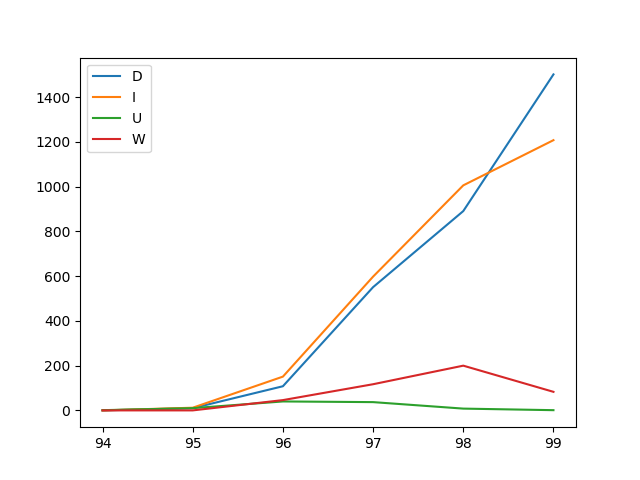

,D,I,U,W
94,0,0,1,0
95,10,12,10,0
96,108,151,40,46
97,551,598,37,117
98,891,1006,8,200
99,1502,1208,1,83


In [33]:

# Extract the years at scale 3
# The year is coded in the index
years = set(int(g.index(vid)) for vid in g.vertices(scale=3))
print sorted(years)

#print [g.class_name(vid) for vid in g.vertices(scale=3)]

classes = set(g.class_name(vid) for vid in g.vertices(scale=3))
print classes

d = {}

for _class in classes:
    d[_class] = {}
    for _year in years:
        d[_class][_year] = 0
        
################################
# TODO
# Modify the following code

for vid in g.vertices(scale=3):
    _class = g.class_name(vid)
    _year = int(g.index(vid))
    d[_class][_year] += 1

################################


print d

# Build a Data frame for the dict
df = pd.DataFrame.from_dict(d)
df.plot()
df

In [35]:
# Export to a pandas dataframe for processing in R

# We need a dict with columns class, year and number

dd = datadict = {'class':[], 'year': [], 'number':[]}
for k in d:
    for y in d[k]:
        dd['class'].append(k)
        dd['year'].append(y)
        dd['number'].append(d[k][y])
        

df = pd.DataFrame(data=dd, index=None, columns=['class', 'year', 'number'])
df.sort_values(['class', 'year'])
df.to_csv('result_GU_num.csv', index=None)
# You can view the content by uncomment the following line
df

,class,year,number
0,I,96,151
1,I,97,598
2,I,98,1006
3,I,99,1208
4,I,94,0
5,I,95,12
6,U,96,40
7,U,97,37
8,U,98,8
9,U,99,1


## Exercise : Extract for each Growth Unit the number of metamer (components at scale 4)

**TODO**: 
* Extract all the vertices at GU scale
* For each GU, extract the number of components (use `nb_components`) 
* Implement the function `data`

In [39]:
GUs = g.vertices(scale=3)

################################
# TODO

def data(vid):
    """ TODO 
    Return vid, the class name and the number of metamers per GU
    """
    class_name = g.class_name(vid)
    nb_metamers = g.nb_components(vid)
    return [vid, class_name, nb_metamers]

################################

nb_metamers = [data(vid) for vid in GUs]

df_gu = pd.DataFrame(nb_metamers, columns=['vid', 'class', 'number'])

df_gu.to_csv('result_metamer_num.csv', index=None)
df_gu

,vid,class,number
0,3,U,55
1,30,I,1
2,32,D,1
3,34,D,1
4,36,I,1
5,38,D,1
6,40,I,1
7,42,D,1
8,44,I,3
9,47,D,1


## Exercise : Extract the number of ramification from each growth unit

**Help**: To extract the number of ramification, use  `g.Sons(vid, EdgeType='+')`

In [44]:
# You can use the method Sons on MTG

################################
# TODO: Implement the following line
def data_ramif(vid):
    """ TODO 
    Return vid, the class name and the number of metamers per GU
    """
    class_name = g.class_name(vid)
    nb_ramif = len(g.Sons(vid,EdgeType = '+'))
    return vid, class_name, nb_ramif

nb_ramifs = [data_ramif(vid) for vid in GUs]



################################

df_ramif = pd.DataFrame(nb_ramifs, columns=['vid', 'class', 'nb_ramifs'])
df_ramif.to_csv('result_branch_num.csv', index=None)
df_ramif

,vid,class,nb_ramifs
0,3,U,16
1,30,I,1
2,32,D,0
3,34,D,0
4,36,I,1
5,38,D,0
6,40,I,1
7,42,D,0
8,44,I,2
9,47,D,0


## Exercise: For each vertex at scale Metamer (scale =4), population of ramifications and position

- vertex of the complex
- Class of complex
- year of complex
- position / rank of each metamer
- if no ramification, put B (blind) else the class of the complex of its child


In [46]:
def rank(v):
    """ Returns the rank of a vertex within its complex. """
    cid = g.complex(v)
    root_in_complex = g.component_roots(cid)[0]
    return g.Height(root_in_complex, v)

ramif_location = []

################################
# TODO

for vid in g.vertices(scale=4):
    # TODO : implement the following lines
    complex_id = g.complex(vid)
    c_class = g.class_name(complex_id) # class of the complex
    c_year = g.index(complex_id) # year of the complex
    metamer_rank = rank(vid) #
    ramifs = g.Sons(vid,EdgeType='+') # list of ramifications of the vid
    nb_ramifs = len(ramifs) # number of ramification
    
    # Class of the complex of the ramif:
    ramif_class = g.class_name(g.complex(ramifs[0])) if (nb_ramifs != 0) else 'B' 
    
    ramif_location.append((complex_id, c_class, c_year, metamer_rank, nb_ramifs, ramif_class))

################################

    
df_pop = pd.DataFrame(ramif_location, columns=['cid', 'class', 'year', 'metamer_rank', 'number_ramif', 'ramif_class'])
df_pop.to_csv('result_ramif_location.csv', index=None)
    
df_pop

,cid,class,year,metamer_rank,number_ramif,ramif_class
0,3,U,94,0,0,B
1,3,U,94,1,0,B
2,3,U,94,2,0,B
3,3,U,94,3,0,B
4,3,U,94,4,0,B
5,3,U,94,5,0,B
6,3,U,94,6,0,B
7,3,U,94,7,0,B
8,3,U,94,8,0,B
9,3,U,94,9,0,B


## Exercise : For each vertex at scale Metamer, population of ramifications and position

- vertex of the complex
- Class of complex
- year of complex
- position / rank of each metamer
- if no ramification, put B (blind) else the class of the complex of its child


In [13]:
ramif_location = []

################################
# TODO 

for vid in g.vertices(scale=4):
    complex_id = g.complex(vid)
    c_class = g.class_name(complex_id)
    c_year = int(g.index(complex_id))
    metamer_rank = rank(vid)
    ramifs = g.Sons(vid, EdgeType='+')
    if ramifs and g.class_name(g.complex(ramifs[0])) == "I":
        # Todo: Retrieve the vegetative GU following the inflorescence (due to sympodial growth: EdgeType='+')
        # Get the type of the first vegetative GU
        # And the number of ramifications
        nb_ramifs = 0
        ramif_class = 'I'
    else:
        nb_ramifs = 0   
        ramif_class = g.class_name(g.complex(ramifs[0])) if (nb_ramifs != 0) else 'B' 
    
    ramif_location.append((complex_id, c_class, c_year, metamer_rank, nb_ramifs, ramif_class))

################################

df_pop = pd.DataFrame(ramif_location, columns=['cid', 'class', 'year', 'metamer_rank', 'number_ramif', 'ramif_class'])
df_pop.to_csv('result_ramif_location_variant.csv', index=None)

## Exercise : For each year, and each type  give the number of successor of each type

For all the Growth Unit of a given class and  year : 
- get the number of successor (its child whose edge_type is '<') of each type

There is a particular case for inflorescences:
- In case of inflo GrowthUnit (class I), the successor is a ramification (edge-type == '+') due to its sympodial nature.



In [15]:
# {'D', 'I', 'U', 'W'} with I : inflorescence
classes = set(g.class_name(vid) for vid in g.vertices(scale=3))


d = {}

for c in classes:
    d[c] = {}
    for y in years:
        d[c][y] = {}
        for sc in classes:
            d[c][y][sc] = 0

        
def my_successors(vid):
    if g.class_name(vid) != 'I':
        cid = g.Successor(vid)
        if cid is not None:
            return [cid]
        else:
            return []
    else:
        return g.children(vid)

################################
# TODO

for vid in GUs:
    _class = g.class_name(vid)
    _year = 94
    kids = my_successors(vid)
    for cid in kids:
        s_class = 'I'
        d[_class][_year][s_class] += 1

################################

# This part is used transform the dict into a list of rows
# 
successors = []
for klass in d:
    for _year in d[klass]:
        data = [klass, _year]
        for succ_klass in classes:
            data.append(d[klass][_year][succ_klass])
        successors.append(data)

columns= ['class', 'year']+list(classes)

df_successors = pd.DataFrame(successors, columns=columns)
df_successors.to_csv('result_successors.csv', index=None)
#df_successors

## Plot the geometry of the Tree

Open an other notebook by clicking below:

[Plot the trees with PlantFrame Algorithm](3D_plot.ipynb)

![3dtree][3dtree]
[3dtree]: ./breaburn_3d.png
